In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import namedtuple, deque, OrderedDict
import torch
import time
import torch.nn.functional as F
import copy
from torch import nn
import torch.optim as optim
from scipy import signal
from torchviz import make_dot
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def np_to_torch(a):
    """
    Convert numpy array into a pytorch tensor and send to device
    """
    return torch.from_numpy(a).float().to(device)


def scale_weights(model, scale):
    """
    Multiply all model weights by a given multiplier.
    """
    for param in model.parameters():
        param.data.copy_(param.data * scale)


class ActorNetwork(nn.Module):
    """
    An actor network which simultaneously prescribes an action to take as a fucntion of state.
    """
    
    def __init__(self, state_size, action_size, seed, hidden_sizes_list):
        """Initialize parameters and build model.
        
        Inputs:
            state_size (int): Dimension of each state.
            action_size (int): Dimension of each action.
            seed (int): Random seed.
            hidden_sizes_list (list): The sizes of hidden layers in the network.
        """
        super(ActorNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        model = OrderedDict([
            ['fc_1', nn.Linear(state_size, hidden_sizes_list[0])],
            ['relu_1', nn.ReLU()]
        ])
        for i in range(1, len(hidden_sizes_list)):
            model['fc_{}'.format(i + 1)] = nn.Linear(hidden_sizes_list[i - 1], hidden_sizes_list[i])
            model['relu_{}'.format(i + 1)] = nn.ReLU()
        model['fc_output'] = nn.Linear(hidden_sizes_list[-1], action_size)
        self.model = nn.Sequential(model)
        self.tanh = nn.Tanh()

    def forward(self, state):
        """ Forward propagation through the network."""
        return self.tanh(self.model(state))


class CriticNetwork(nn.Module):
    """
    A critic network which predicts the action value for a state.
    Action is inserted as an input to the last hidden layer.
    """
    
    def __init__(self, state_size, action_size, seed, hidden_sizes_list):
        """Initialize parameters and build model.
        
        Inputs:
            state_size (int): Dimension of each state.
            action_size (int): Dimension of each action.
            seed (int): Random seed.
            hidden_sizes_list (list): The sizes of hidden layers in the network.
        """
        super(CriticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        model_first_part = OrderedDict([
            ['fc_1', nn.Linear(state_size, hidden_sizes_list[0])],
            ['relu_1', nn.ReLU()]
        ])
        self.model_first_part = nn.Sequential(model_first_part)
        model_second_part = OrderedDict()
        for i in range(1, len(hidden_sizes_list)):
            model_second_part['fc_{}'.format(i + 1)] = nn.Linear(hidden_sizes_list[i - 1] + action_size * (i==1), hidden_sizes_list[i])
            model_second_part['relu_{}'.format(i + 1)] = nn.ReLU()
        self.model_second_part = nn.Sequential(model_second_part)
        self.output_layer = nn.Linear(hidden_sizes_list[-1], 1)

    def forward(self, state, action):
        """ Forward propagation through the network."""
        x = self.model_first_part(state)
        x = torch.cat([x, action], 1)
        x = self.model_second_part(x)
        x = self.output_layer(x)
        return x

In [3]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Inputs:
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, states, actions, rewards, next_states, dones):
        """Add a set of new experiences to memory.
        
        Inputs:
            states: Current state
            actions: Action taken in the current state.
            rewards: Reward received at the current step.
            next_states: A state into which the transition occurs.
            dones: An indicator of the transition learding into a terminal state.
        """
        if states.ndim == 1:
            es = [self.experience(states, actions, rewards, next_states, dones)]
        else:
            es = [self.experience(states[i], actions[i], rewards[i], next_states[i], dones[i]) for i in range(states.shape[0])]
        for e in es:
            self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, self.batch_size)

        states = np_to_torch(np.vstack([e.state for e in experiences if e is not None]))
        actions = np_to_torch(np.vstack([e.action for e in experiences if e is not None]))
        rewards = np_to_torch(np.vstack([e.reward for e in experiences if e is not None]))
        next_states = np_to_torch(np.vstack([e.next_state for e in experiences if e is not None]))
        dones = np_to_torch(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8))
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [4]:
class OUProcess():
    """
    Orstein-Uhlenbeck process.
    """
    
    def __init__(self, theta, sigma, dims, mu=0.0):
        self.theta = theta
        self.sigma = sigma
        self.dims = dims
        self.mu = mu
        self.values = np.ones(dims) * mu
        
    def sample(self):
        self.values += self.theta * (self.mu - self.values) + self.sigma * np.random.normal(size=self.dims)
        return self.values

class Agent():
    """
    An RL agent which can interact with an environment and learn from replayed experiences.
    Uses an actor-critic method for continuous actions (DDPG).
    """
    
    def __init__(self, num_instances, state_size, action_size, seed, actor_hidden_sizes_list, critic_hidden_sizes_list,
                 num_iters_learn=1, update_every=4, batch_size=128, gamma=0.99, buffer_size=int(1e6),
                 update_target_network_every=1, actor_lr0=1e-4, critic_lr0=1e-3,
                 noise_theta=0.15, noise_sigma=0.2, noise_sigma_decay=1.0, weight_decay=0.0,
                 actor_reg_loss_weight=0.0, random_seed=0):
        """ Initialize an Agent object.
        
        Inputs:
            num_instances (int): Number of actors running in parallel.
            state_size (int): The dimensionality of the state space.
            action_size (int): Number of possible actions an agent can take.
            seed (int): Randomization seed.
            actor_hidden_sizes_list (list): The sizes of hidden layers in the actor network.
            critic_hidden_sizes_list (list): The sizes of hidden layers in the critic network.
            num_iters_learn (int, optional): Number of iterations to take at each step towards the targets.
            update_every (int, optional): How often the main networks are updated (default 1).
            batch_size (int, optional): Batch size for each upate (default 64).
            gamma (float, optional): Temporal discount coefficient (default 0.99).
            buffer_size (int, optional): Maximum capacity of the replay buffer (default 1e6).
            update_target_network_every (int, optional): How often to update the target network (default 1).
            actor_lr0 (float, optional): Initial learning rate for the actor (default 1e-4).
            critic_lr0 (float, optional): Initial learning rate for the critic (default 1e-3).
            noise_theta (float): Parameter of Ornstein-Uhlenbeck noise process.
            noise_sigma (float): Parameter of Ornstein-Uhlenbeck noise process.
            noise_sigma_decay (float): Multiplier for noise_sigma (per episode).
            weight_decay (float): Weight decay parameter for both actor and critic networks.
            actor_reg_loss_weight (float): Weight placed on L2 norm of actions.
            random_seed (int): Seed for pseudo-random numbers.
        """
        self.num_instances = num_instances
        self.action_size = action_size
        self.state_size = state_size
        self.seed = seed
        self.num_iters_learn = num_iters_learn
        self.update_every = update_every
        self.batch_size = batch_size
        self.gamma = gamma
        self.actor_lr0 = actor_lr0
        self.critic_lr0 = critic_lr0
        self.update_target_network_every = update_target_network_every
        self.actor_network_main = ActorNetwork(state_size, action_size, seed, actor_hidden_sizes_list).to(device)
        self.actor_network_target = ActorNetwork(state_size, action_size, seed, actor_hidden_sizes_list).to(device)
        scale_weights(self.actor_network_main, 0.01)
        self.soft_update(self.actor_network_main, self.actor_network_target, tau=1.0)
        self.actor_network_target.eval()
        
        self.critic_network_main = CriticNetwork(state_size, action_size, seed, critic_hidden_sizes_list).to(device)
        self.critic_network_target = CriticNetwork(state_size, action_size, seed, critic_hidden_sizes_list).to(device)
        scale_weights(self.critic_network_main, 0.01)
        self.soft_update(self.critic_network_main, self.critic_network_target, tau=1.0)
        self.critic_network_target.eval()
        
        self.actor_optimizer = optim.Adam(self.actor_network_main.parameters(), lr=actor_lr0, weight_decay=weight_decay)
        self.critic_optimizer = optim.Adam(self.critic_network_main.parameters(), lr=critic_lr0, weight_decay=weight_decay)
        self.actor_reg_loss_weight = actor_reg_loss_weight
        self.actor_reg_loss_fn = lambda x: F.mse_loss(x, torch.zeros_like(x))
        

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        # Initialize time step (for updating every "update_every" steps)
        self.t_step = 0
        # Initialize OU noise
        self.noise = OUProcess(theta=noise_theta, sigma=noise_sigma, dims=(num_instances, action_size))
        self.noise_sigma_decay = noise_sigma_decay

    def step(self, states, actions, rewards, next_states, dones):       
        """
        Process a vector of state changes.
        Periodically learn (update network) if enough experiences are available in the replay buffer.
        
        Inputs:
            states: Current state
            actions: Action taken in the current state.
            rewards: Reward received at the current step.
            next_states: A state into which the transition occurs.
            dones: An indicator of the transition learding into a terminal state.
        """
        
        # Save experience in replay memory
        self.memory.add(states, actions, rewards, next_states, dones)
 
        self.t_step += 1
        if self.t_step % self.update_every == 0: # Learn every "update_every" time steps.
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)
        
               
    def act(self, states):
        """Returns actions for given states as per current policy.
        
        Inputs:
            states (array_like): current states
            eps (float): epsilon, for epsilon-greedy action selection
        """
        states = torch.from_numpy(states).float().to(device)
        self.actor_network_main.eval()
        with torch.no_grad():
            actions = self.actor_network_main(states).cpu().data.numpy()
        self.actor_network_main.train()
        return np.tanh(np.arctanh(actions) + self.noise.sample())
#         return np.clip(actions + self.noise.sample(), -1, 1)

                
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Inputs:
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        for _ in range(self.num_iters_learn):
            # get targets for the critic network
            with torch.no_grad():
                actor_target_next_actions = self.actor_network_target(next_states)
                Q_targets_next = self.critic_network_target(next_states, actor_target_next_actions)
                critic_targets = (rewards + gamma * Q_targets_next * (1 - dones)).squeeze()
            
            # update critic
            critic_predictions = self.critic_network_main(states, actions).squeeze()
            critic_loss = F.mse_loss(critic_predictions, critic_targets)
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
            # update actor
            actor_proposed_actions = self.actor_network_main(states)
            actor_objective = self.critic_network_main(states, actor_proposed_actions).mean()
            actor_loss = -actor_objective + self.actor_reg_loss_weight * self.actor_reg_loss_fn(actor_proposed_actions)
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
        
        if self.t_step % self.update_target_network_every == 0:
            self.soft_update(self.critic_network_main, self.critic_network_target, 1e-3)
            self.soft_update(self.actor_network_main, self.actor_network_target, 1e-3)

    def soft_update(self, main_model, target_model, tau=1e-3):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Inputs:
            main_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), main_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [5]:
env = UnityEnvironment(file_name='Reacher_20.app')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

agent = Agent(num_instances=num_agents,
              state_size=state_size,
              action_size=action_size,
              seed=0,
              actor_hidden_sizes_list=[256, 128],
              critic_hidden_sizes_list=[256, 128],
              gamma=0.99,
              num_iters_learn=1,
              actor_lr0=1e-4,
              critic_lr0=1e-4,
              weight_decay=1e-6,
              actor_reg_loss_weight=0.0,
              update_every=1,
              noise_sigma=0.2,
              noise_sigma_decay=0.99,
              buffer_size=int(1e5),
              batch_size=128)
scores = []

def ddqn(env, agent, scores, n_episodes=150, max_t=10000, save_every=10,
        lr_decay_episode=0.996, actor_min_lr = 3e-7, critic_min_lr = 3e-6):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        save_every (int): How often to save the checkpoints
        lr_decay_episode (float): Learning rate decay multiplier (per episode)
        actor_min_lr (float): Minimum actor learning rate (capped at the bottom at this value)
        critic_min_lr (float): Minimum critic learning rate (capped at the bottom at this value)
    """
    scores_window = deque(maxlen=100)  # last 100 scores
    hundred_episodes_start_time = time.time()
    solved = False
    for i_episode in range(1, n_episodes+1):
        for param_group in agent.actor_optimizer.param_groups:
            # adjust actor learning rate
            param_group['lr'] = max(agent.actor_lr0 * lr_decay_episode**i_episode, actor_min_lr)
        for param_group in agent.critic_optimizer.param_groups:
            # adjust critic learning rate
            param_group['lr'] = max(agent.critic_lr0 * lr_decay_episode**i_episode, critic_min_lr)
        # reduce action noise variance
        agent.noise.sigma *= agent.noise_sigma_decay
        episode_start_time = time.time()
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations            # get the current state
        score = 0
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[env.brain_names[0]]        # send the actions to the environment
            next_states = env_info.vector_observations   # get the next states
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            score += np.mean(rewards)                                # update the score
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states                             # roll over the state to next time step
            if np.any(dones):                                       # exit loop if episode finished
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        episode_end_time = time.time()
        print('\rEpisode {}\tCurrent Score: {:.2f}\tAverage Score: {:.2f}, episode took {:.2f} seconds'.format(i_episode,
            score, np.mean(scores_window), episode_end_time - episode_start_time))
        if i_episode % save_every == 0:
            hundred_episodes_end_time = time.time()
            torch.save(agent.actor_network_main.state_dict(), 'checkpoints/checkpoint_actor_{}.pth'.format(i_episode))
            torch.save(agent.critic_network_main.state_dict(), 'checkpoints/checkpoint_critic_{}.pth'.format(i_episode))
            hundred_episodes_start_time = time.time()
        if (np.mean(scores_window) >= 30.0) & ~solved:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,\
                np.mean(scores_window)))
            torch.save(agent.actor_network_main.state_dict(), 'checkpoints/final_checkpoint_actor.pth')
            torch.save(agent.critic_network_main.state_dict(), 'checkpoints/final_checkpoint_critic.pth')
            break
            
ddqn(env, agent, scores)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in arctanh


Episode 1	Current Score: 0.38	Average Score: 0.38, episode took 12.35 seconds
Episode 2	Current Score: 0.25	Average Score: 0.32, episode took 11.96 seconds
Episode 3	Current Score: 0.63	Average Score: 0.42, episode took 12.56 seconds
Episode 4	Current Score: 0.59	Average Score: 0.46, episode took 12.48 seconds
Episode 5	Current Score: 0.47	Average Score: 0.46, episode took 12.12 seconds
Episode 6	Current Score: 0.52	Average Score: 0.47, episode took 12.49 seconds
Episode 7	Current Score: 1.02	Average Score: 0.55, episode took 14.09 seconds
Episode 8	Current Score: 1.12	Average Score: 0.62, episode took 14.38 seconds
Episode 9	Current Score: 1.06	Average Score: 0.67, episode took 14.27 seconds
Episode 10	Current Score: 1.49	Average Score: 0.75, episode took 14.26 seconds
Episode 11	Current Score: 1.76	Average Score: 0.85, episode took 14.28 seconds
Episode 12	Current Score: 2.13	Average Score: 0.95, episode took 14.33 seconds
Episode 13	Current Score: 2.45	Average Score: 1.07, episode t

Episode 103	Current Score: 34.44	Average Score: 29.41, episode took 15.30 seconds
Episode 104	Current Score: 33.85	Average Score: 29.74, episode took 15.20 seconds
Episode 105	Current Score: 36.50	Average Score: 30.10, episode took 15.33 seconds

Environment solved in 5 episodes!	Average Score: 30.10


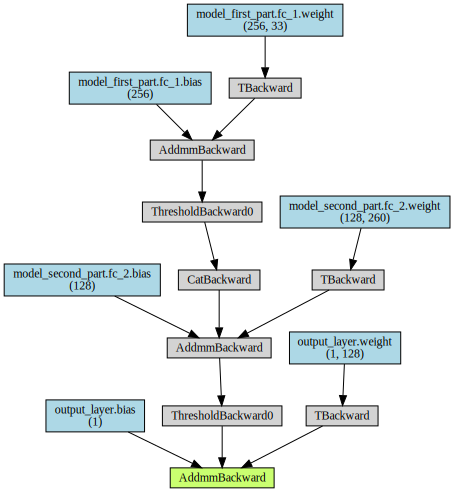

In [6]:
model = agent.critic_network_main
make_dot(model(torch.randn(1,33), torch.randn(1,4)), params=dict(model.named_parameters()))

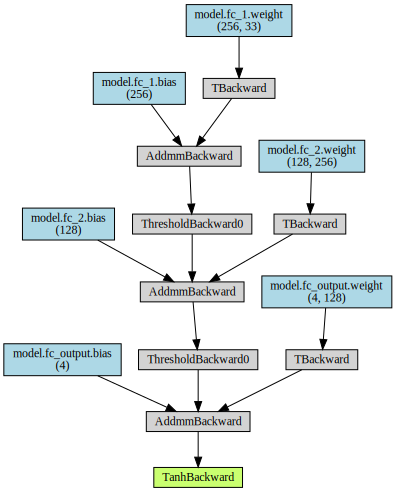

In [8]:
model = agent.actor_network_main
make_dot(model(torch.randn(1,33)), params=dict(model.named_parameters()))

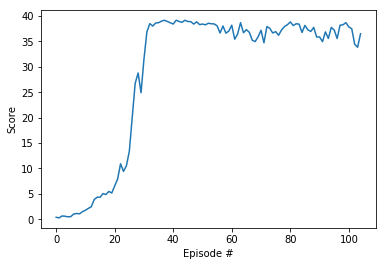

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

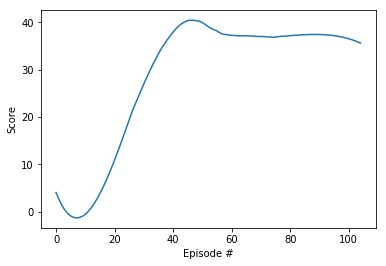

In [10]:
plt.plot(np.arange(len(scores)), signal.savgol_filter(scores, 53, 3))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Demonstrate the trained agent

In [5]:
num_agents = 20
state_size = 33
action_size = 4

agent = Agent(num_instances=num_agents,
              state_size=state_size,
              action_size=action_size,
              seed=0,
              actor_hidden_sizes_list=[256, 128],
              critic_hidden_sizes_list=[256, 128],
              gamma=0.99,
              num_iters_learn=1,
              actor_lr0=0.0,
              critic_lr0=0.0,
              weight_decay=0.0,
              actor_reg_loss_weight=0.0,
              update_every=100000000,
              noise_sigma=0.0,
              noise_sigma_decay=0.0,
              buffer_size=int(1e5),
              batch_size=128)

In [6]:
actor_checkpoint = torch.load('checkpoints/final_checkpoint_actor.pth')
critic_checkpoint = torch.load('checkpoints/final_checkpoint_critic.pth')

agent.actor_network_main.load_state_dict(actor_checkpoint)
agent.critic_network_main.load_state_dict(critic_checkpoint)

In [7]:
env = UnityEnvironment(file_name='Reacher_20.app')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
states = env_info.vector_observations            # get the current state
score = 0
for t in range(1000):
    actions = agent.act(states)
    env_info = env.step(actions)[env.brain_names[0]]        # send the actions to the environment
    next_states = env_info.vector_observations   # get the next states
    rewards = env_info.rewards                   # get the reward
    dones = env_info.local_done                  # see if episode has finished
    score += np.mean(rewards)                                # update the score
    agent.step(states, actions, rewards, next_states, dones)
    states = next_states                             # roll over the state to next time step

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in arctanh
